In [1]:
from typing import *
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
sns.set_context("notebook")

# Presentation 2023-05-30

Findings r.e. 4-8-bit quantisation:

 - At 8-bits, channel scaling is good (E2M5), but simple per-tensor scaling is possible with an extra exponent bit (E3M4)
 - E2M* or scaled-INT* perform similarly
 - Reducing group size is no substitute for more mantissa bits


In [104]:
df = pd.concat([
    pd.read_json("../../out/2023-05-quantisation-4-8bit/4-8bit_refresh.jsonl", lines=True).assign(sweep="main"),
    pd.read_json("../../out/sweep_v2_extra.jsonl", lines=True).assign(sweep="extra"),
]).reset_index()
df = df.rename(columns={
     c: dict(outcompare="oc", arc_easy="arc", lambada_openai="lam")[c.split(":")[0]] + "_" + c.split(":")[1]
     for c in df.columns
     if ":" in c})

def get_element_stats(d: Dict[str, Any]) -> Dict[str, Any]:
     if d["_type"] in ["fp", "ieee"]:
          return dict(
               element_dtype=f"E{d['exponent_bits']}M{d['mantissa_bits']}",
               element_dtype_kind=f"E{d['exponent_bits']}",
               element_dtype_bits=1 + d['exponent_bits'] + d['mantissa_bits'],
          )
     if d["_type"] == "int":
          return dict(
               element_dtype=f"E0M{d['bits_']-1}",
               element_dtype_kind="int",
               element_dtype_bits=d['bits_'],
          )
     if d["_type"] == "lut":
          return dict(
               element_dtype=f"LUT{int(np.log2(len(d['values'])))}[{d['name']}]",
               element_dtype_kind=d['name'],
               element_dtype_bits=int(np.log2(len(d["values"]))),
          )
     assert d["_type"] == "linear", d["_type"]
     return dict(
          get_element_stats(d["element_format"]),
          scale_combiner=d["scale_combiner"] or "none",
          group_size=min((g for group in d["group_shapes"] for g in group if g not in {1, None}), default=None),
     )

df["model"] = df["model"].apply(lambda s: s.split("/")[1])
df["compression"] = df["quantised_bytes"] / (2 * df["parameters"])
df = df.join(df["format"].apply(get_element_stats).apply(pd.Series))

print(f"{len(df)} rows")
print("models", df.model.unique())
df.tail()[["model", "format_name", "scale_combiner", "group_size", "oc_entropy_rmse", "oc_time"]]

295 rows
models ['pythia-410m' 'pythia-1.4b' 'pythia-2.8b']


,model,format_name,scale_combiner,group_size,oc_entropy_rmse,oc_time
290,pythia-2.8b,LUT8[NF-approx]{1.*:E5M10},none,NaN,0.017807,2122.374334
291,pythia-1.4b,E0M3{1.16:E5M10},none,16.0,0.227181,831.435088
292,pythia-1.4b,E0M3{1.8:E5M10},none,8.0,0.187980,991.029852
293,pythia-1.4b,E0M3{1.4:E5M10},none,4.0,0.142245,802.258111
294,pythia-1.4b,E0M3{1.2:E5M10},none,2.0,0.095651,955.372901


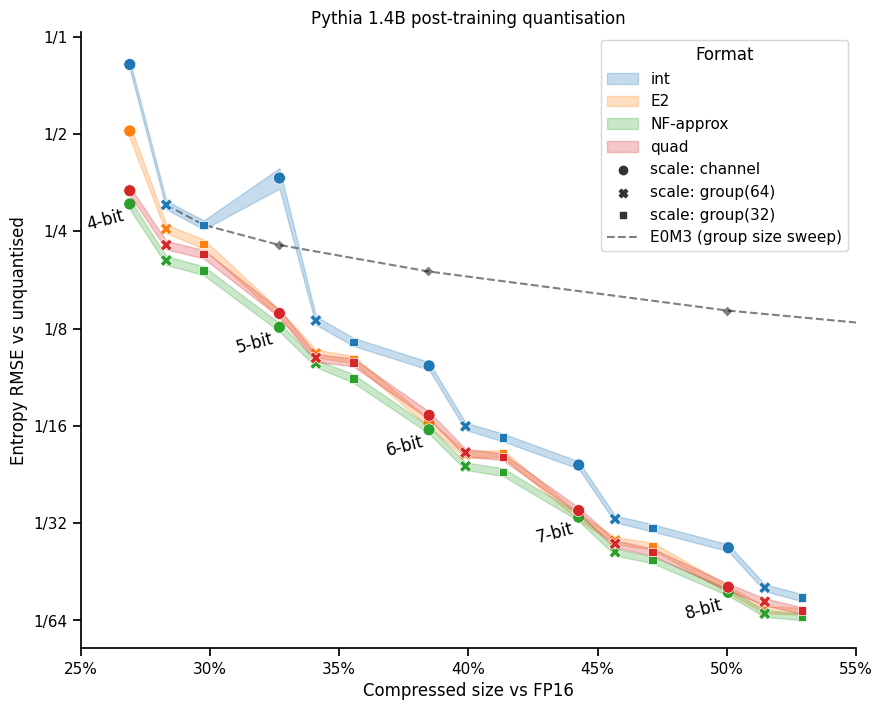

In [147]:
d = (df
    .pipe(lambda d: d[d.model == "pythia-1.4b"])
    .pipe(lambda d: d[d.scale_combiner == "none"])
    .pipe(lambda d: d[d.group_size.isna() | (d.group_size >= 32)])
    .pipe(lambda d: d.assign(scaling_mode=d.group_size.apply(lambda g: f"scale: group({int(g)})" if not np.isnan(g) else "scale: channel")))
)

plt.figure(figsize=(10, 8))
ax = plt.gca()
for (kind, g), color in zip(d.groupby("element_dtype_kind", sort=False), sns.color_palette()):
    # sns.lineplot(data=g, y="oc_entropy_rmse", x="compression", color=color, ax=ax, lw=2, label=kind)
    g = g.sort_values("compression")
    ax.fill_between(g.compression, g.oc_entropy_rmse - 2*g.oc_entropy_rmse_stderr, g.oc_entropy_rmse + 2*g.oc_entropy_rmse_stderr, label=kind,
                    color=color, alpha=0.25)
    sns.scatterplot(data=g, y="oc_entropy_rmse", x="compression", color=color, ax=ax, s=75, linewidth=0.5,
                    style="scaling_mode", style_order=["scale: channel", "scale: group(64)", "scale: group(32)"], legend=(kind == "quad"))
    if kind == "NF-approx":
        for _, s in g[g.group_size.isna()].iterrows():
            ax.annotate(f"{s.element_dtype_bits}-bit", [s["compression"], s["oc_entropy_rmse"]],
                        fontsize=12, ha="right", va="top", xytext=(-6, -2), textcoords="offset points",
                        rotation=15, rotation_mode="anchor")
ax.plot("compression", "oc_entropy_rmse", "k--",
        data=df[(df.model == "pythia-1.4b") & (df.element_dtype == "E0M3") & ~df.group_size.isna()].sort_values("compression"),
        label="E0M3 (group size sweep)", alpha=0.5, zorder=0)
ax.scatter("compression", "oc_entropy_rmse", color="k", marker="D", s=25,
           data=df[(df.model == "pythia-1.4b") & (df.element_dtype == "E0M3") & (df.group_size <= 16)].sort_values("compression"),
           label="_nolabel", alpha=0.5, linewidth=0)
ax.set_yscale("log", base=2)
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: f"1/{1/x:.0f}"))
ax.set_xlim((0.25, 0.55))
ax.legend(loc="upper right", title="Format")
ax.set_xlabel("Compressed size vs FP16")
ax.set_ylabel(f"Entropy RMSE vs unquantised")
ax.set_title("Pythia 1.4B post-training quantisation")
sns.despine();